# Shallow water equations

This is an example how `sparsegrad` can be used to generate Jacobian of finite element system of three coupled equations. 

The model solved is:

$\frac{\partial (\rho \eta) }{\partial t} + \frac{\partial (\rho \eta u)}{\partial x} + \frac{\partial (\rho \eta v)}{\partial y} = 0$

$\frac{\partial (\rho \eta u)}{\partial t} + \frac{\partial}{\partial x}\left( \rho \eta u^2 + \frac{1}{2}\rho g \eta^2 \right) + \frac{\partial (\rho \eta u v)}{\partial y} = 0$

$\frac{\partial (\rho \eta v)}{\partial t} + \frac{\partial (\rho \eta uv)}{\partial x} + \frac{\partial}{\partial y}\left(\rho \eta v^2 + \frac{1}{2}\rho g \eta ^2\right) = 0$

with $\rho = 1$.

For simplicity, upwinding is not included. 

In [1]:
%matplotlib inline
import scipy.sparse.linalg 
from pylab import imshow,colorbar,show,title,plot
from sparsegrad.base import *
from sparsegrad.forward import *
import numpy as np

In [2]:
class mesh:
    """Rectangular mesh of size (n,n) with grid_spacing, providing cell centered
    d_dx and d_dy operators"""
    def __init__(self,n,grid_spacing):
        self.n=n
        self.grid_spacing=grid_spacing
        self.ndof=n*n
        self.idx=np.zeros((n,n),dtype=int)
        self.idx.ravel()[:]=np.arange(self.ndof)
        x,y = np.mgrid[:n,:n]
        self.x = x.flatten()
        self.y = y.flatten()
        
        def deriv_op(axis,p=1,m=-1):
            idx_p1=np.roll(self.idx,-p,axis).flatten()
            idx_m1=np.roll(self.idx,-m,axis).flatten()
            adx=forward.seed(np.zeros_like(self.idx.flatten()))
            return ((adx[idx_p1]-adx[idx_m1])/((p-m)*grid_spacing)).dvalue
        
        self.d_dx_mat = deriv_op(0)
        self.d_dy_mat = deriv_op(1)
        
    def d_dx(self,x):
        return dot(self.d_dx_mat,x)
    
    def d_dy(self,x):
        return dot(self.d_dy_mat,x)
    
    def twodim(self,x):
        x2=np.zeros((self.n,self.n))
        x2.ravel()[:]=x
        return x2
        
    def zeros(self):
        return np.zeros(self.ndof)

def timestep(xold,dt,tol,ltol=1e-5):
    "Timestep solver using Newton's method with bicgstab"
    x=xold.copy()
    for i in range(1,10):
        adx=forward.seed(x)
        adxt = (adx-xold)/dt
        adf=residuals(adx,adxt)
        f,df=adf.value,adf.dvalue
        fnorm=np.linalg.norm(f)
        print('\tNonlinear {i}, |F|={f}'.format(i=i,f=fnorm))
        if fnorm<tol:
            print('Converged')
            return x
        def callback(*args):
            pass
        delta,status=scipy.sparse.linalg.bicgstab(scipy.sparse.linalg.aslinearoperator(df),-f,callback=callback,
                                                 tol=np.linalg.norm(f)*ltol)
        if status:
            raise RuntimeError('linear solver did not converge to tolerance{ltol}'.format(ltol=ltol))
        x+=delta
    raise RuntimeError('did not converge to tolerance {tol}'.format(tol))

## Solution of example problem

In [3]:
box_size = 1.

n=200
m=mesh(n,box_size/n)
d_dx=m.d_dx
d_dy=m.d_dy        

g=1

def fields_to_x(eta,u,v):
    return stack(eta,u,v)
def x_to_fields(x):
    return x[:m.ndof],x[m.ndof:2*m.ndof],x[2*m.ndof:]

def residuals(x,xt):
    eta,u,v=x_to_fields(x)
    deta_dt = -d_dx(eta*u) - d_dy(eta*v)
    du_dt = (deta_dt*u - d_dx(eta*u**2 + 1./2*g*eta**2) - d_dy(eta*u*v)) / eta
    dv_dt = (deta_dt*v - d_dx(eta*u*v) - d_dy(eta*v**2 + 1./2*g*eta**2)) / eta
    return xt-fields_to_x(deta_dt,du_dt,dv_dt)

In [5]:
eta = np.where((m.x-n/2)**2+(m.y-n/2)**2<10**2,1.1,1)
x0 = fields_to_x(eta, m.zeros(), m.zeros())
dt=0.005
time=0
x=x0
for i in range(60):
    print('Timestep {i} at time {time} with dt {dt}'.format(i=i,time=time,dt=dt))
    x=timestep(x,dt,1e-2)
    time+=dt

Timestep 0 at time 0 with dt 0.005
	Nonlinear 1, |F|=123.70850168209854
	Nonlinear 2, |F|=4.652501903260688
	Nonlinear 3, |F|=0.004442327061870622
Converged
Timestep 1 at time 0.005 with dt 0.005
	Nonlinear 1, |F|=97.94726808760322
	Nonlinear 2, |F|=1.3045409124697653
	Nonlinear 3, |F|=0.00024951294362157077
Converged
Timestep 2 at time 0.01 with dt 0.005
	Nonlinear 1, |F|=81.56933753776647
	Nonlinear 2, |F|=0.5827935443458024
	Nonlinear 3, |F|=3.542538021861456e-05
Converged
Timestep 3 at time 0.015 with dt 0.005
	Nonlinear 1, |F|=70.65426412921472
	Nonlinear 2, |F|=0.3638393254177026
	Nonlinear 3, |F|=1.2577151344104771e-05
Converged
Timestep 4 at time 0.02 with dt 0.005
	Nonlinear 1, |F|=63.3233084153314
	Nonlinear 2, |F|=0.25165510354432213
	Nonlinear 3, |F|=5.746688517453546e-06
Converged
Timestep 5 at time 0.025 with dt 0.005
	Nonlinear 1, |F|=58.2084500555132
	Nonlinear 2, |F|=0.18798321727786774
	Nonlinear 3, |F|=3.356674638495452e-06
Converged
Timestep 6 at time 0.030000000000

	Nonlinear 2, |F|=0.0038975703112441593
Converged
Timestep 52 at time 0.2600000000000001 with dt 0.005
	Nonlinear 1, |F|=20.913751888743963
	Nonlinear 2, |F|=0.005440510338175537
Converged
Timestep 53 at time 0.2650000000000001 with dt 0.005
	Nonlinear 1, |F|=20.667262282171993
	Nonlinear 2, |F|=0.0036406347698701423
Converged
Timestep 54 at time 0.27000000000000013 with dt 0.005
	Nonlinear 1, |F|=20.426532859369125
	Nonlinear 2, |F|=0.005178588773988263
Converged
Timestep 55 at time 0.27500000000000013 with dt 0.005
	Nonlinear 1, |F|=20.191463707132417
	Nonlinear 2, |F|=0.0032562884083951957
Converged
Timestep 56 at time 0.28000000000000014 with dt 0.005
	Nonlinear 1, |F|=19.9617437415888
	Nonlinear 2, |F|=0.005110236088791264
Converged
Timestep 57 at time 0.28500000000000014 with dt 0.005
	Nonlinear 1, |F|=19.737301114699008
	Nonlinear 2, |F|=0.002994991581514517
Converged
Timestep 58 at time 0.29000000000000015 with dt 0.005
	Nonlinear 1, |F|=19.51783206330254
	Nonlinear 2, |F|=0.00

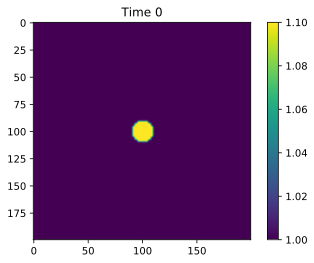

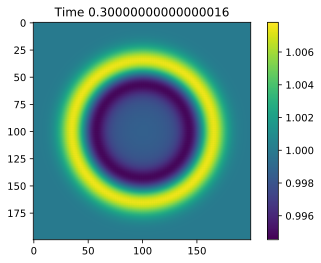

In [6]:
title('Time {time}'.format(time=0))
imshow(m.twodim(x_to_fields(x0)[0]),interpolation='bicubic')
colorbar()
show()
title('Time {time}'.format(time=time))
imshow(m.twodim(x_to_fields(x)[0]),interpolation='bicubic')
colorbar()
show()

## Runtime cost of automatic differentiation

In [7]:
%timeit -n 10 residuals(x,0.)

2.05 ms ± 160 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
adx=forward.seed(x)

In [9]:
%timeit -n 10 residuals(adx,0.*adx)

104 ms ± 1.57 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
residuals(adx,0.*adx).value

array([ -1.74026350e-11,  -2.63760566e-11,  -2.24258084e-11, ...,
        -2.47766252e-11,  -1.56532565e-11,  -7.08411108e-12])

In [11]:
residuals(adx,0.*adx).dvalue

<120000x120000 sparse matrix of type '<class 'numpy.float64'>'
	with 1280000 stored elements in Compressed Sparse Row format>